In [60]:
import re
import os
import sys
import time
import json
import joblib
import traceback
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import timedelta, datetime
from dateutil.relativedelta import relativedelta

from tools import *
from scorecardpipeline import *

logger = init_setting(seed=999, logger=True)
use_cols = ['指标名称', '指标含义', '分箱', '样本总数', '样本占比', '好样本数', '好样本占比', '坏样本数', '坏样本占比', '坏样本率', 'LIFT值', '累积LIFT值']
json_cols = ["app_id", "supplier_code", "data_source_code", "result_value", "apply_result", "reason_code", "expire_date"]
feature_describe = pd.read_excel("common/百融征信打包字段.xlsx").rename(columns={"var_name_en": "变量名", "note": "字段"})[["变量名", "字段"]].drop_duplicates("变量名")

feature_map = dict(zip(feature_describe["变量名"], feature_describe["字段"]))

In [61]:
def timestamp2datetime(stamp,format='%Y-%m-%d %H:%M:%S'):
    if not isinstance(stamp, int):
        try:
            stamp = int(stamp)
        except ValueError as error:
            raise Exception(f"timestamp is not digital. error info {error}")

    if len(str(stamp)) == 10:
        _ = time.localtime(stamp)
        _ = time.strftime(format, _)
        return datetime.strptime(_, format)
    elif 10 < len(str(stamp)) < 15:
        _ = len(str(stamp)) - 10
        _ = datetime.fromtimestamp(stamp/(1 * 10 ** _))
        return _.strftime(format)
    else:
        return


def asnumeric(data):
    numeric_columns = []
    for col in data.columns:
        try:
            data[col] = pd.to_numeric(data[col])
        except:
            pass
    
    return data


def deal_td_risk_items(items):
    """
    同盾数据解析方法
    """
    results = {}
    
    for item in items:
        group_name = item.get("group") or ""
        item_name = item.get("item_name") or ""
        
        results.update({f"{group_name}_{item_name}_score": item.get("score")})
        # results.update({f"{group_name}_{item_name}_level": item.get("risk_level")})
        
        item_detail = item.get('item_detail', {})
        
        if item_detail:
            try:
                results.update({f"{group_name}_{item_name}_count": item_detail.get("platform_count")})
                
                high_risk_areas = item_detail.get('high_risk_areas', {})
                frequency_detail_list = item_detail.get('frequency_detail_list', {})
                platform_detail = item_detail.get('platform_detail', {})
                platform_detail_dimension = item_detail.get('platform_detail_dimension', {})
                
                if high_risk_areas:
                    results.update({f"{group_name}_{item_name}_high_risk_areas": high_risk_areas, f"{group_name}_{item_name}_high_risk_areas_count": len(high_risk_areas)})
                
                if frequency_detail_list:
                    for detail in frequency_detail_list:
                        detail_info = detail.get("detail", "：").split("：")
                        results.update({f"{group_name}_{item_name}_{detail_info[0]}_count": int(detail_info[1])})
                
                if platform_detail:
                    for detail in platform_detail:
                        detail_info = detail.split(":")
                        results.update({f"{group_name}_{item_name}_{detail_info[0]}_count": int(detail_info[1])})
                
                if platform_detail_dimension:
                    for dimension in platform_detail_dimension:
                        dimension_name = dimension.get("dimension") or ""
                        results.update({f"{group_name}_{item_name}_{dimension_name}_count": dimension.get("count")})
                        
                        for detail in dimension.get("detail", []):
                            detail_info = detail.split(":")
                            results.update({f"{group_name}_{item_name}_{dimension_name}_{detail_info[0]}_count": int(detail_info[1])})
            except:
                traceback.print_exc()
                print("item_detail", item_detail, "\n")
    
    return results


def td_parase_data(path):
    if "xlsx" in path:
        td_data = pd.read_excel(path)[json_cols]
    else:
        with open(path, "r", encoding="utf8") as f:
            td_data = pd.DataFrame(json.load(f)["data"])[json_cols]
    
    td_data["result_value"] = td_data["result_value"].apply(json.loads)

    cols = ["final_score", "final_decision", "report_time", "report_id", "apply_time", "application_id"]
    td_data[cols] = td_data["result_value"].apply(lambda x: [x.get(c) for c in cols]).apply(pd.Series)

    cols = ["mobile_address", "id_card_address"]
    td_data[cols] = td_data["result_value"].apply(lambda x: x.get("address_detect", {})).apply(lambda x: [x.get(c) for c in cols]).apply(pd.Series)
    td_data["risk_items"] = td_data["result_value"].apply(lambda x: x.get("risk_items", {}))
    td_data["apply_time"] = pd.to_datetime(td_data["apply_time"].apply(timestamp2datetime))
    td_data["report_time"] = pd.to_datetime(td_data["report_time"].apply(timestamp2datetime))

    td_data = td_data.join(td_data["risk_items"].apply(deal_td_risk_items).apply(pd.Series))
    td_data = td_data.sort_values("report_time").drop_duplicates("app_id", keep="last")
    td_data = td_data.drop(columns=["result_value", "risk_items", "supplier_code", "data_source_code", "apply_result", "reason_code", "expire_date", "report_id", "apply_time", "application_id"])
    
    td_data = asnumeric(td_data.rename(columns={"app_id": "订单编号"}).replace("", np.nan))
    
    return td_data


def br_parase_data(path):
    """
    百融征信数据解析
    """
    with open(path, "r", encoding="utf8") as f:
        br_data = pd.DataFrame(json.load(f)["data"])[json_cols]
        br_data["result_value"] = br_data["result_value"].replace("	(N/A)", "{}").replace("(N/A)", "{}").apply(json.loads)
        br_data = br_data.join(br_data["result_value"].apply(pd.Series))
        # br_data["expire_date"] = pd.to_datetime(br_data["expire_date"])
        
        br_data = br_data.sort_values("expire_date").drop_duplicates("app_id", keep="last")
        br_data = br_data.drop(columns=["result_value", "expire_date", "supplier_code", "data_source_code", "apply_result", "reason_code", "code", "swift_number"])
        
        br_data = asnumeric(br_data.rename(columns={"app_id": "订单编号"}).replace("", np.nan))
    
    return br_data

In [67]:
data = pd.read_sql_query("""
                        SELECT C_EXT_ID
                                , D_APPLICATION
                                , N_AGE
                                , N_MAX_OVERDUE_DAYS
                                , N_OVERDUE_DAYS
                                , CASE WHEN N_MAX_OVERDUE_DAYS > 30 THEN 1 ELSE 0 END TARGET
                                , N_TENOR
                                , C_INDUSTRY_TWO
                                , C_EDUCATION
                                , XGB_SCORE
                        FROM DATAMART.DM_MID_LOAN_BASE l
                        left join (
                            SELECT C_APP_ID, MIN(X492) xgb_score
                            FROM DATAMART.DM_MID_URULE_PARAM
                            WHERE C_TARGET_NAME like 'education%' AND X492 IS NOT NULL
                            GROUP BY C_APP_ID
                        ) s ON s.C_APP_ID = l.C_EXT_ID
                        WHERE C_EXT_ID IN (
                                                SELECT C_EXT_ID FROM (
                                                        SELECT C_CUST_IDNO, C_EXT_ID, ROW_NUMBER() OVER(PARTITION BY C_CUST_IDNO ORDER BY D_APPLICATION) rk FROM DATAMART.DM_MID_LOAN_BASE
                                                        WHERE D_APPLICATION >= DATE '2022-01-01' (N_MAX_OVERDUE_DAYS > 30 OR N_MAX_OVERDUE_DAYS <= 0)
                                                ) t WHERE rk = 1
                                        )
                                        AND D_APPLICATION >= DATE '2022-01-01' AND D_LOAN_DATE <= DATE '2022-12-31' AND C_FINANCE_PRODUCT_CODE NOT LIKE '%DDG%' AND (N_MAX_OVERDUE_DAYS > 30 OR N_MAX_OVERDUE_DAYS <= 0)
                        """, cx.connect("zhangluping/zhangluping#0210@172.16.104.109:1521/geexdb")
                        )

data.shape, data["TARGET"].sum()

((2747, 10), 487)

In [68]:
# 验证数据集
oot_data = pd.read_sql_query("""
                        SELECT C_EXT_ID
                                , D_APPLICATION
                                , N_AGE
                                , N_MAX_OVERDUE_DAYS
                                , N_OVERDUE_DAYS
                                , CASE WHEN N_MAX_OVERDUE_DAYS > 30 THEN 1 ELSE 0 END TARGET
                                , N_TENOR
                                , C_INDUSTRY_TWO
                                , C_EDUCATION
                                , XGB_SCORE
                        FROM DATAMART.DM_MID_LOAN_BASE l
                        left join (
                            SELECT C_APP_ID, MIN(X492) xgb_score
                            FROM DATAMART.DM_MID_URULE_PARAM
                            WHERE C_TARGET_NAME like 'education%' AND X492 IS NOT NULL
                            GROUP BY C_APP_ID
                        ) s ON s.C_APP_ID = l.C_EXT_ID
                        WHERE C_EXT_ID IN (
                                                SELECT C_EXT_ID FROM (
                                                        SELECT C_CUST_IDNO, C_EXT_ID, ROW_NUMBER() OVER(PARTITION BY C_CUST_IDNO ORDER BY D_APPLICATION) rk FROM DATAMART.DM_MID_LOAN_BASE
                                                        WHERE D_APPLICATION >= DATE '2022-01-01' AND (N_MAX_OVERDUE_DAYS > 30 OR N_MAX_OVERDUE_DAYS <= 0)
                                                ) t WHERE rk = 1
                                        )
                                        AND D_LOAN_DATE >= DATE '2023-01-01' AND D_LOAN_DATE <= DATE '2023-04-30' AND C_FINANCE_PRODUCT_CODE NOT LIKE '%DDG%' AND (N_MAX_OVERDUE_DAYS > 30 OR N_MAX_OVERDUE_DAYS <= 0)
                        """, cx.connect("zhangluping/zhangluping#0210@172.16.104.109:1521/geexdb")
                        )

oot_data.shape, oot_data["TARGET"].sum()

((920, 10), 54)

In [69]:
# 职培同盾百融数据
br_data1 = br_parase_data("export_result (69).json")
td_data1 = td_parase_data("export_result (71).json")

train = data.rename(columns={"C_EXT_ID": "订单编号"}).merge(br_data1, on="订单编号", how="inner").merge(td_data1, on="订单编号", how="inner")

del_cols = [
#             "多平台借贷申请检测_12个月内申请人在多个平台申请借款_借款人身份证详情_银行消费金融公司_count", "多平台借贷申请检测_近60个月以上申请人在多个平台申请借款_借款人手机详情_大型消费金融公司_count",
#             "ir_id_x_name_cnt", "多平台借贷申请检测_12个月内申请人在多个平台申请借款_银行消费金融公司_count", "多平台借贷申请检测_6个月内申请人在多个平台申请借款_银行消费金融公司_count", 
#             "als_lst_id_bank_inteday", "多平台借贷申请检测_近60个月以上申请人在多个平台申请借款_大型消费金融公司_count", "多平台借贷申请检测_近60个月以上申请人在多个平台申请借款_借款人身份证详情_大型消费金融公司_count",
#             "多平台借贷申请检测_18个月内申请人在多个平台申请借款_借款人手机详情_一般消费分期平台_count", "多平台借贷申请检测_近60个月以上申请人在多个平台申请借款_银行消费金融公司_count",
#             "多平台借贷申请检测_近60个月以上申请人在多个平台申请借款_借款人身份证详情_银行消费金融公司_count", 
            "C_EDUCATION", "C_INDUSTRY_TWO"
           ]
for col in train.columns:
    if len(train[col].value_counts()) < 2:
        del_cols.append(col)


train = train.drop(columns=["个人基本信息核查_身份证归属地位于高风险较为集中地区_high_risk_areas", "id_card_address", "mobile_address", "final_decision", 
                            "D_APPLICATION", "N_MAX_OVERDUE_DAYS", "N_OVERDUE_DAYS", "订单编号", "N_TENOR", "report_time"] + del_cols)

train = train.reset_index(drop=True)

In [70]:
# 职培同盾百融数据
br_data1 = br_parase_data(r"export_result (76).json")
td_data1 = td_parase_data(r"export_result (75).json")

oot = oot_data.rename(columns={"C_EXT_ID": "订单编号"}).merge(br_data1, on="订单编号", how="inner").merge(td_data1, on="订单编号", how="inner")
oot = oot.drop(columns=[c for c in oot.columns if c in ["个人基本信息核查_身份证归属地位于高风险较为集中地区_high_risk_areas", "id_card_address", "mobile_address", "final_decision", 
                            "D_APPLICATION", "N_MAX_OVERDUE_DAYS", "N_OVERDUE_DAYS", "订单编号", "N_TENOR", "report_time"] + del_cols])

# oot = oot.drop(columns=["C_INDUSTRY_TWO"]).reset_index(drop=True)
oot = oot.reset_index(drop=True)

In [73]:
target = "TARGET"

In [209]:
# 构建 pipeline
pre_select = FeatureSelection(target=target, engine="toad", identical=0.95, empty=0.95, corr=0.9, iv=0.05)
temp_train = pre_select.fit_transform(train.drop(columns=["XGB_SCORE"]))
temp_oot = pre_select.transform(oot)

combiner = Combiner(target=target, empty_separate=True, method="cart", min_bin_size=0.12, max_n_prebins=5, min_prebin_size=0.05, max_n_bins=2)
combiner.fit(temp_train)

combiner.combiner.update({
    "C_EDUCATION": [["本科", "研究生"], ["大专"], ["中专、职高、技校", "高中", "技术学校"], ["初中及以下", "初中", "小学", "文盲或半文盲"], ["其他", np.nan, None, "其它"]],
    "als_m3_id_bank_min_inteday": [8, np.nan],
    "als_m3_cell_pdl_allnum": [2, np.nan],
    "als_m1_id_caon_allnum": [np.nan],
    "als_m3_cell_nbank_else_allnum": [2, np.nan],
    "als_m3_id_nbank_nsloan_orgnum": [2, np.nan],
    "ir_id_x_cell_lastchg_days": [106.0, np.nan],
    "多平台借贷申请检测_24个月内申请人在多个平台申请借款_银行消费金融公司_count": [2, np.nan],
    "als_m1_id_nbank_nsloan_orgnum": [1, np.nan],
    "als_m6_id_cooff_orgnum": [1, np.nan],
    "多平台借贷申请检测_18个月内申请人在多个平台申请借款_大型消费金融公司_count": [1, np.nan],
    "多平台借贷负债检测_近60个月以上申请人在多个平台被放款_借款人身份证详情_一般消费分期平台_count": [2, np.nan],
    "多平台借贷申请检测_6个月内申请人在多个平台申请借款_借款人身份证详情_O2O_count": [1, np.nan],
})


for k, v in combiner.rules.items():
    if len(v) <= 1 and pd.isnull(v[0]):
        combiner.update({k: [1.]})

temp_train = combiner.transform(temp_train)
temp_oot = combiner.transform(temp_oot)

transform = WOETransformer(target=target)
woe_train = transform.fit_transform(temp_train)
woe_oot = transform.fit_transform(temp_oot)

In [210]:
import joblib
from automl.aml_main import auto_lightgbm
from sklearn.model_selection import train_test_split

woe_train['订单编号'] = [i for i in range(len(woe_train))]

In [211]:
uid, dep = "订单编号", "TARGET"
var_names = list(woe_train.columns)
var_names.remove(dep)
# woe_train, woe_oot = train_test_split(woe_train, test_size=0.25, random_state=328)
datasets = {"dev": woe_train, "off": woe_train}

In [212]:
lgb_base = auto_lightgbm(datasets, dep, var_names, uid, params={'num_threads': 4, 'colsample_bytree': 0.8, 'metric': 'cross_entropy', 'num_leaves': 2**5}, early_stopping_rounds=5)
model, new_var_names = lgb_base.train(
                                        select_feature=True, #特征筛选
                                        select_type='shap',   #特征筛选指标
                                        single_delete=True,   #逐个特征删除
                                        imp_threhold=1e-3,    #特征筛选指标阈值
                                        corr_threhold=0.35,    #相关系数阈值
                                        psi_threhold=0.1,     #PSI阈值
                                        target='offks',      #参数搜索目标函数
                                        params_weight=0.,    #weight目标函数权重
                                     )

开始自动建模...
--------------------------------------------------
Shap阈值 0.001
shap删除特征个数： 172 shap保留特征个数： 142
--------------------------------------------------
相关性阈值: 0.35 相关性删除特征个数： 124 相关性保留特征个数： 18
--------------------------------------------------
PSI阈值 0.1
PSI删除特征个数： 0 PSI保留特征个数： 18
--------------------------------------------------
['ir_id_x_cell_lastchg_days', 'als_m6_id_bank_night_orgnum', 'als_fst_id_bank_inteday', 'als_m6_id_nbank_else_orgnum', 'als_m3_id_bank_min_inteday', 'als_m3_cell_pdl_allnum', 'als_m1_id_caon_allnum', 'als_m6_cell_cooff_allnum', 'als_d15_id_rel_allnum', 'als_m12_cell_coon_allnum', '多平台借贷申请检测_近60个月以上申请人在多个平台申请借款_借款人身份证详情_P2P网贷_count', '多平台借贷申请检测_近60个月以上申请人在多个平台申请借款_信用卡中心_count', '多平台借贷申请检测_6个月内申请人在多个平台申请借款_借款人身份证详情_O2O_count', '多平台借贷申请检测_近60个月以上申请人在多个平台申请借款_借款人身份证详情_银行个人业务_count', '多平台借贷申请检测_3个月内申请人在多个平台申请借款_借款人身份证详情_一般消费分期平台_count', '多平台借贷申请检测_24个月内申请人在多个平台申请借款_小额贷款公司_count', '多平台借贷申请检测_24个月内申请人在多个平台申请借款_大型消费金融公司_count', '多平台借贷申请检测_近60个月以上申请人在多个平台申请借款_借款人身

  0%|                                                                                          | 0/18 [00:00<?, ?it/s]

--------------------------------------------------
Best params:  {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'cross_entropy', 'reg_lambda': 3, 'reg_alpha': 1.85, 'num_leaves': 32, 'learning_rate': 0.01999999999999999, 'min_data': 50, 'min_hessian': 0.05000000000000002, 'num_threads': 4, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.7999999999999999, 'bagging_freq': 2, 'verbose': -1, 'num_boost_round': 100}
--------------------------------------------------
开始逐步删除特征 	
train_number: 0, offks: 0.44609788122520144


 17%|█████████████▋                                                                    | 3/18 [00:00<00:01,  9.09it/s]

(Good) train_n: 2, offks: 0.44842496992483 by vars: als_m6_id_bank_night_orgnum


100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  7.56it/s]


(End) train_n: 35, offks: 0.4418311533319462 del_list_vars: ['als_m6_id_bank_night_orgnum']
逐步删除特征个数： 1 逐步保留特征个数： 17
--------------------------------------------------
KS & PSI:  {'devks': 0.44842496992483, 'offks': 0.44842496992483, 'offpsi': 0.0}
--------------------------------------------------
AutoML建模完成


In [223]:
# 逻辑回归变量删除
# new_var_names.remove("als_m3_id_bank_min_inteday")

In [224]:
logistic = ITLubberLogisticRegression(target=target, class_weight={1: 0.9, 0: 0.1}, C=10, max_iter=50)
logistic.fit(woe_train[new_var_names + [target]])
logistic.summary().sort_values(["Coef."], ascending=True)

,Coef.,Std.Err,z,P>|z|,[ 0.025,0.975 ],VIF
als_m6_id_nbank_else_orgnum,0.0909,0.1567,0.5802,0.5618,-0.2162,0.3979,1.4404
als_d15_id_rel_allnum,0.1133,0.2129,0.5321,0.5946,-0.3039,0.5305,1.1416
多平台借贷申请检测_24个月内申请人在多个平台申请借款_大型消费金融公司_count,0.1411,0.1423,0.9916,0.3214,-0.1378,0.4199,1.2459
多平台借贷申请检测_3个月内申请人在多个平台申请借款_借款人身份证详情_一般消费分期平台_count,0.1502,0.1588,0.9459,0.3442,-0.1611,0.4616,1.2451
als_m12_cell_coon_allnum,0.1532,0.2134,0.7179,0.4728,-0.2650,0.5713,1.1848
多平台借贷申请检测_近60个月以上申请人在多个平台申请借款_借款人身份证详情_财产保险_count,0.1909,0.2136,0.8937,0.3715,-0.2278,0.6096,1.1524
als_m1_id_caon_allnum,0.3384,0.1601,2.1129,0.0346,0.0245,0.6522,1.2692
多平台借贷申请检测_24个月内申请人在多个平台申请借款_小额贷款公司_count,0.3534,0.1384,2.5545,0.0106,0.0823,0.6246,1.2543
ir_id_x_cell_lastchg_days,0.3592,0.1147,3.1329,0.0017,0.1345,0.5839,1.1821
als_m3_cell_pdl_allnum,0.3898,0.1418,2.7486,0.0060,0.1118,0.6678,1.2505


In [216]:
# col = "多平台借贷申请检测_近60个月以上申请人在多个平台申请借款_借款人身份证详情_财产保险_count"
# feature_table = feature_bin_stats(train, col, target=target, desc=feature_map.get(col, col), combiner=combiner)
# _ = bin_plot(feature_table, desc=feature_map.get(col, col), figsize=(8, 4), save=f"model_report/bin_plots/data_{col}.png")

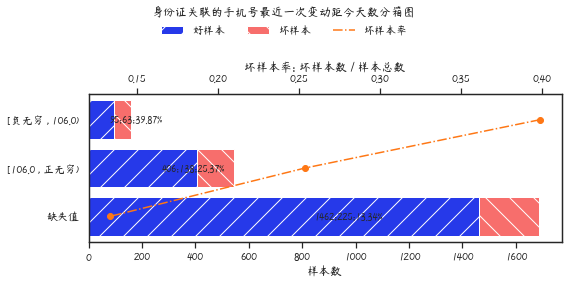

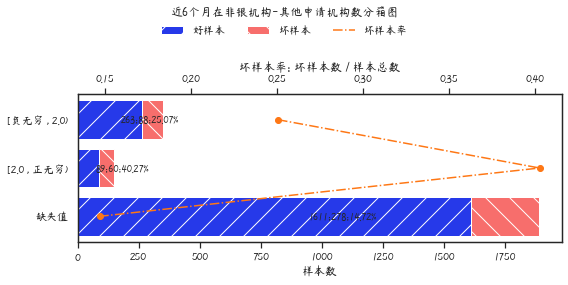

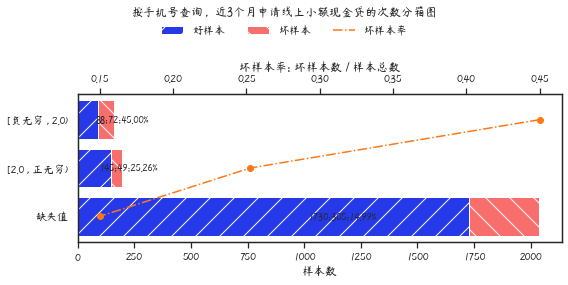

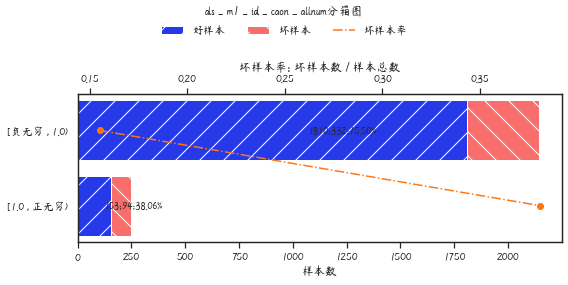

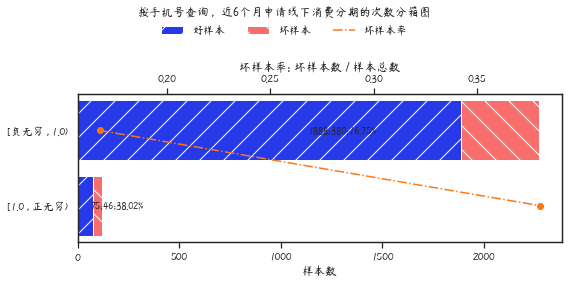

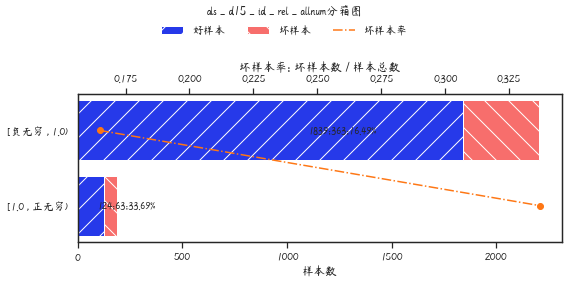

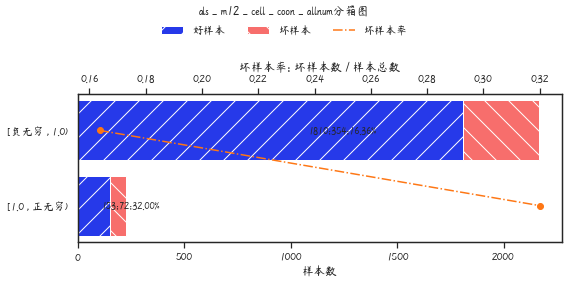

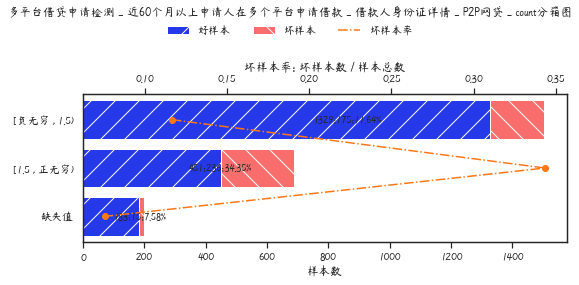

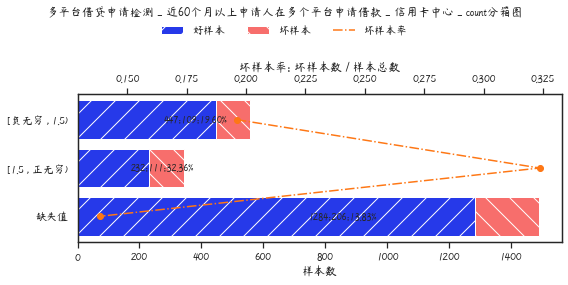

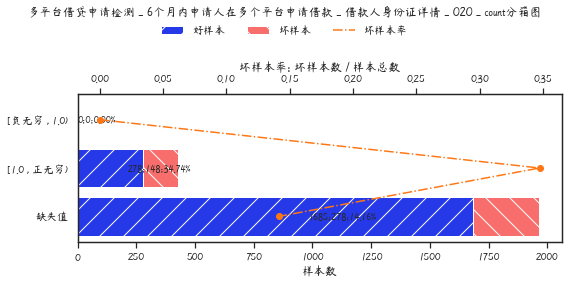

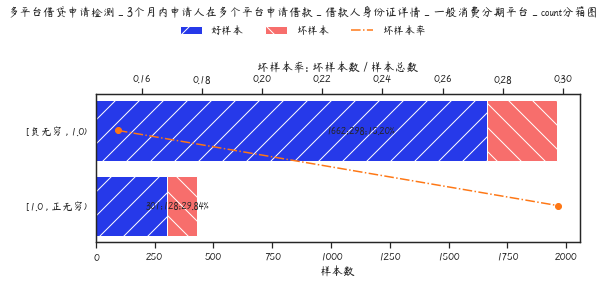

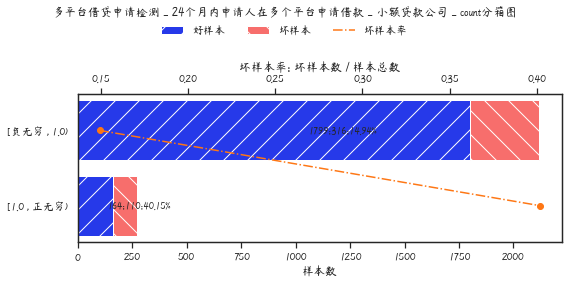

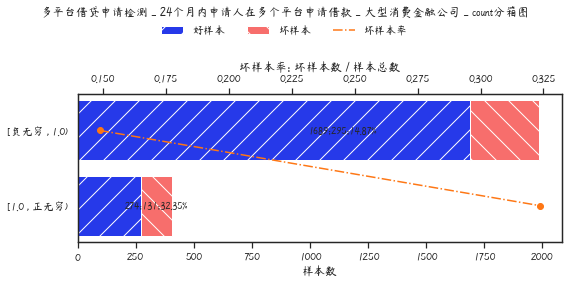

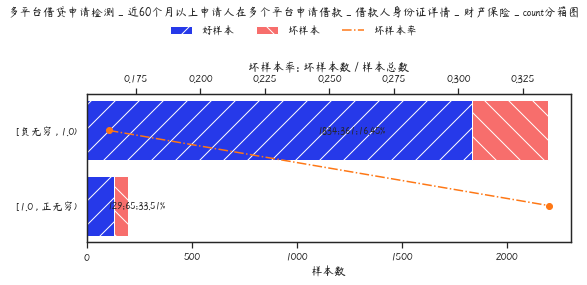

In [225]:
for col in logistic.feature_names_in_:
    feature_table = feature_bin_stats(train, col, target=target, desc=feature_map.get(col, col), combiner=combiner)
    _ = bin_plot(feature_table, desc=feature_map.get(col, col), figsize=(8, 4), save=f"model_report/bin_plots/data_{col}.png")

In [226]:
card = ScoreCard(target=target, combiner=combiner, transer=transform, pretrain_lr=logistic, base_score=600, base_odds=0.2, pdo=50)
card.fit(woe_train[new_var_names + [target]])

ScoreCard(base_odds=0.2, base_score=600,
          combiner=<toad.transform.Combiner object at 0x000002615303D400>,
          pdo=50,
          pretrain_lr=ITLubberLogisticRegression(C=10,
                                                 class_weight={0: 0.1, 1: 0.9},
                                                 max_iter=50, target='TARGET'),
          target='TARGET',
          transer=<toad.transform.WOETransformer object at 0x000002614E3CBD00>)

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,LIFT值,累积LIFT值
0,score,,"[负无穷 , 575.7535)",260.0000,0.1088,135.0000,0.0688,125.0000,0.2934,0.4808,2.6961,2.6961
1,score,,"[575.7535 , 606.071)",188.0000,0.0787,123.0000,0.0627,65.0000,0.1526,0.3457,1.9389,2.3784
2,score,,"[606.071 , 624.5664)",142.0000,0.0594,100.0000,0.0509,42.0000,0.0986,0.2958,1.6587,2.2052
3,score,,"[624.5664 , 648.416)",211.0000,0.0883,167.0000,0.0851,44.0000,0.1033,0.2085,1.1694,1.9323
4,score,,"[648.416 , 680.9749)",394.0000,0.1649,336.0000,0.1712,58.0000,0.1362,0.1472,0.8255,1.5674
5,score,,"[680.9749 , 692.0589)",225.0000,0.0942,203.0000,0.1034,22.0000,0.0516,0.0978,0.5483,1.4059
6,score,,"[692.0589 , 699.3025)",237.0000,0.0992,219.0000,0.1116,18.0000,0.0423,0.0759,0.4259,1.2658
7,score,,"[699.3025 , 正无穷)",732.0000,0.3064,680.0000,0.3464,52.0000,0.1221,0.0710,0.3984,1.0000
8,score,,缺失值,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


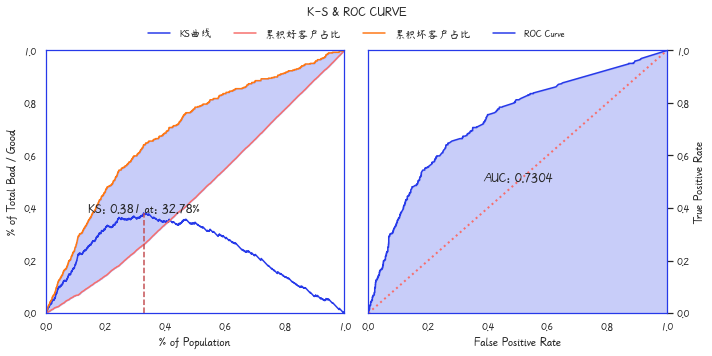

In [227]:
_ = ks_plot(card.predict(train), train[target], figsize=(10, 5))
feature_bin_stats(pd.DataFrame({"score": card.predict(train), "target": train[target]}), "score", max_n_bins=10, method="cart")[use_cols]

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,LIFT值,累积LIFT值
0,score,,"[负无穷 , 570.7376)",62.0000,0.0675,48.0000,0.0554,14.0000,0.2642,0.2258,3.9154,3.9154
1,score,,"[570.7376 , 603.9725)",61.0000,0.0664,53.0000,0.0612,8.0000,0.1509,0.1311,2.2740,3.1014
2,score,,"[603.9725 , 629.6114)",61.0000,0.0664,52.0000,0.0600,9.0000,0.1698,0.1475,2.5583,2.9213
3,score,,"[629.6114 , 647.55)",61.0000,0.0664,58.0000,0.0670,3.0000,0.0566,0.0492,0.8528,2.4063
4,score,,"[647.55 , 661.5176)",61.0000,0.0664,60.0000,0.0693,1.0000,0.0189,0.0164,0.2843,1.9833
5,score,,"[661.5176 , 674.2249)",62.0000,0.0675,60.0000,0.0693,2.0000,0.0377,0.0323,0.5593,1.7434
6,score,,"[674.2249 , 683.715)",51.0000,0.0555,47.0000,0.0543,4.0000,0.0755,0.0784,1.3600,1.6967
7,score,,"[683.715 , 688.085)",46.0000,0.0501,45.0000,0.0520,1.0000,0.0189,0.0217,0.3769,1.5662
8,score,,"[688.085 , 693.7907)",57.0000,0.0620,55.0000,0.0635,2.0000,0.0377,0.0351,0.6084,1.4616
9,score,,"[693.7907 , 698.4955)",87.0000,0.0947,87.0000,0.1005,0.0000,0.0000,0.0000,0.0000,1.2528


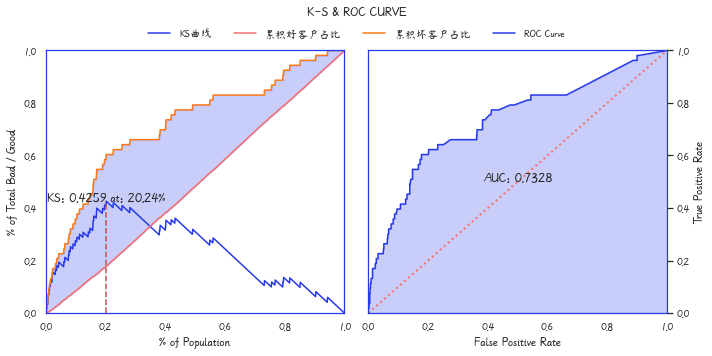

In [248]:
_ = ks_plot(card.predict(oot), oot[target], figsize=(10, 5))
feature_bin_stats(pd.DataFrame({"score": card.predict(oot), "target": oot[target]}), "score", max_n_bins=15, method="quantile")[use_cols]

In [249]:
init_setting()
plt.ioff()

In [250]:
writer = ExcelWriter(theme_color="0000ff")

In [251]:
total_count = len(train) + len(oot)
dataset_summary = pd.DataFrame(
    [
        ["全量样本集", "2022-01-01", "2023-04-30", total_count, total_count / total_count, train[target].sum() + oot[target].sum(), (train[target].sum() + oot[target].sum()) / total_count, "除舞蹈培训、财会以外的职培订单数据，剔除历史逾期(0,30]的的样本"],
        ["跨时间验证集", "2023-01-01", "2023-04-30", len(oot), len(oot) / total_count, oot[target].sum(), oot[target].sum() / len(oot), ""],
        ["建模样本集", "2022-01-01", "2022-12-31", len(train), len(train) / total_count, train[target].sum(), train[target].sum() / len(train), ""],
#         ["训练集", "2022-01-01", "2022-12-31", len(dev), len(dev) / total_count, dev[target].sum(), dev[target].sum() / len(dev), ""],
#         ["测试集", "2022-01-01", "2022-12-31", len(off), len(off) / total_count, off[target].sum(), off[target].sum() / len(off), ""],
    ],
    columns=["数据集", "开始时间", "结束时间", "样本总数", "样本占比", "坏客户数", "坏客户占比", "备注"],
)

# ////////////////////////////////////// 样本说明 ///////////////////////////////////// #
worksheet = writer.get_sheet_by_name("汇总信息")

# 样本总体分布情况
end_row, end_col = writer.insert_value2sheet(worksheet, (2, 2), value="样本总体分布情况", style="header")
end_row, end_col = writer.insert_df2sheet(worksheet, dataset_summary, (end_row + 1, 2), header=True)

writer.set_number_format(worksheet, f"{get_column_letter(end_col - 2)}{end_row - len(dataset_summary)}:{get_column_letter(end_col - 2)}{end_row}", "0.00%")
writer.set_number_format(worksheet, f"{get_column_letter(end_col - 4)}{end_row - len(dataset_summary)}:{get_column_letter(end_col - 4)}{end_row}", "0.00%")

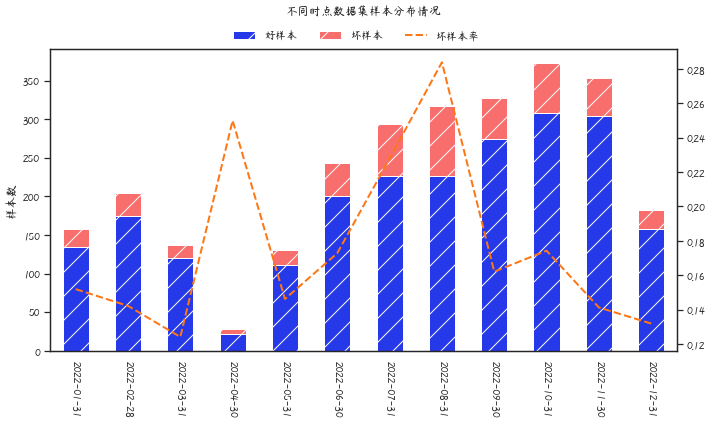

In [252]:
# 样本时间分布情况
temp = distribution_plot(data, date="D_APPLICATION", target="TARGET", save="model_report/建模集样本分布情况.png", result=True)
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, 2), value="建模样本时间分布情况", style="header")
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/建模集样本分布情况.png", (end_row, 2), figsize=(720, 370))
end_row, end_col = writer.insert_df2sheet(worksheet, temp.T.reset_index(), (end_row, 2), header=False)

writer.set_number_format(worksheet, f"{get_column_letter(2)}{end_row - 1}:{get_column_letter(end_col)}{end_row - 1}", "0.00%")
writer.set_number_format(worksheet, f"{get_column_letter(2)}{end_row - 2}:{get_column_letter(end_col)}{end_row - 2}", "0.00%")
writer.set_number_format(worksheet, f"{get_column_letter(2)}{end_row - 4}:{get_column_letter(end_col)}{end_row - 4}", "0.00%")
writer.set_number_format(worksheet, f"{get_column_letter(2)}{end_row - 6}:{get_column_letter(end_col)}{end_row - 6}", "0.00%")

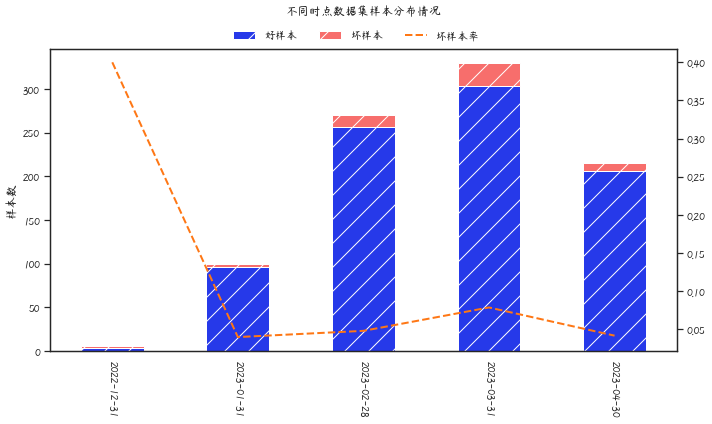

In [253]:
# 样本时间分布情况
temp = distribution_plot(oot_data, date="D_APPLICATION", target="TARGET", save="model_report/跨时间验证集分布情况.png", result=True)
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, 2), value="跨时间验证样本分布情况", style="header")
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/跨时间验证集分布情况.png", (end_row, 2), figsize=(720, 370))
end_row, end_col = writer.insert_df2sheet(worksheet, temp.T.reset_index(), (end_row, 2), header=False)

writer.set_number_format(worksheet, f"{get_column_letter(2)}{end_row - 1}:{get_column_letter(end_col)}{end_row - 1}", "0.00%")
writer.set_number_format(worksheet, f"{get_column_letter(2)}{end_row - 2}:{get_column_letter(end_col)}{end_row - 2}", "0.00%")
writer.set_number_format(worksheet, f"{get_column_letter(2)}{end_row - 4}:{get_column_letter(end_col)}{end_row - 4}", "0.00%")
writer.set_number_format(worksheet, f"{get_column_letter(2)}{end_row - 6}:{get_column_letter(end_col)}{end_row - 6}", "0.00%")

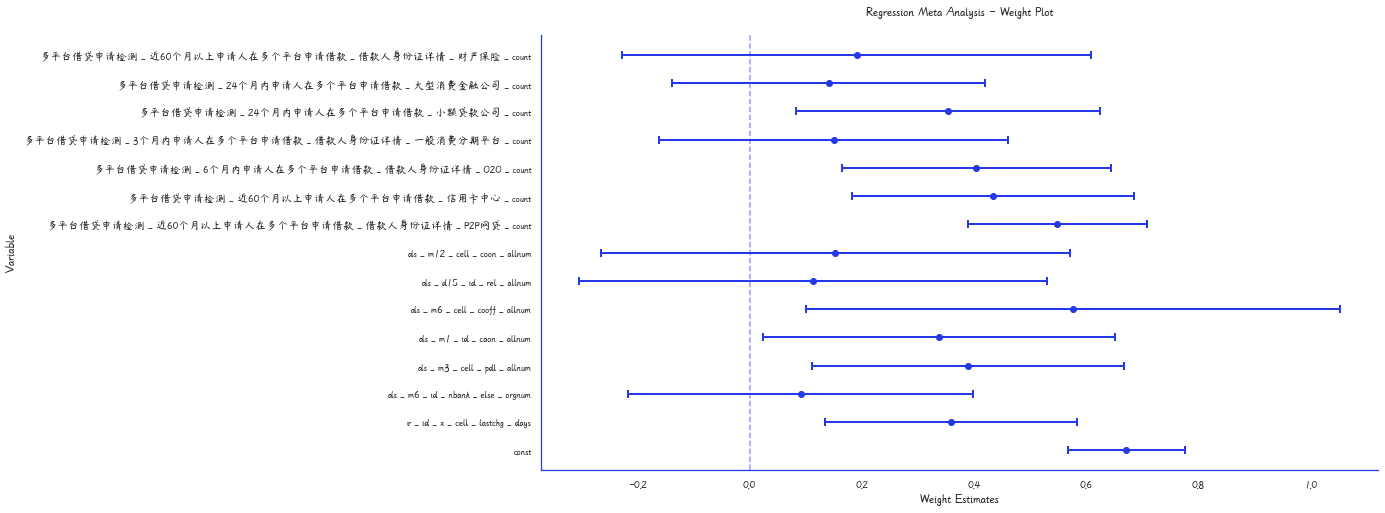

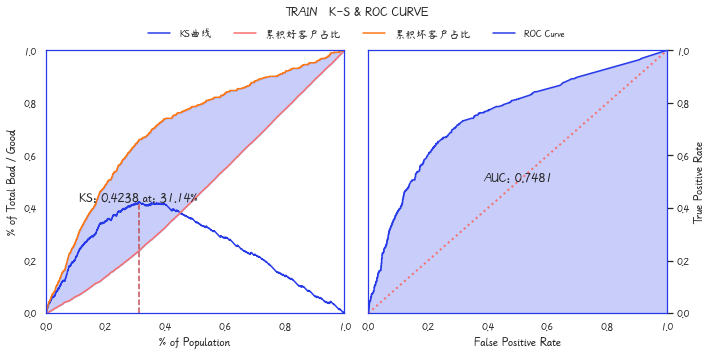

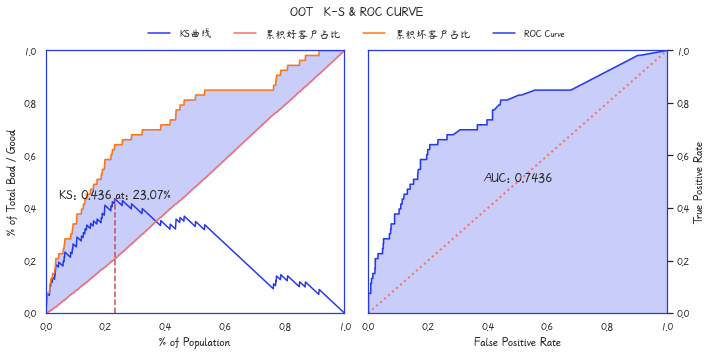

In [254]:
_ = logistic.plot_weights(save="model_report/logistic_train.png")

# 预测
y_pred_train = logistic.predict_proba(woe_train[card.features_])[:, 1]
y_pred_oot = logistic.predict_proba(woe_oot[card.features_])[:, 1]

_ = ks_plot(y_pred_train, woe_train[target], figsize=(10, 5), save="model_report/lr_ksplot_train.png", title="TRAIN \t")
_ = ks_plot(y_pred_oot, woe_oot[target], figsize=(10, 5), save="model_report/lr_ksplot_oot.png", title="OOT \t")

In [255]:
# ////////////////////////////////////// 模型报告 ///////////////////////////////////// #
summary = logistic.summary2(feature_map=feature_map)

# 逻辑回归拟合情况
worksheet = writer.get_sheet_by_name("逻辑回归拟合结果")
start_row, start_col = 2, 2

end_row, end_col = writer.insert_value2sheet(worksheet, (start_row, start_col), value="逻辑回归拟合效果", style="header")
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/logistic_train.png", (end_row + 2, start_col))
end_row, end_col = writer.insert_df2sheet(worksheet, summary, (end_row + 1, start_col))

conditional_column = get_column_letter(start_col + summary.columns.get_loc("Coef."))
writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(summary)}', f'{conditional_column}{end_row}')

end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="建模集拟合报告", style="header")
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/lr_ksplot_train.png", (end_row, start_col), figsize=(480, 270))
end_row, end_col = writer.insert_df2sheet(worksheet, logistic.report(woe_train[card.features_ + [target]]), (end_row + 1, start_col))

end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="跨时间验证集拟合报告", style="header")
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/lr_ksplot_oot.png", (end_row, start_col), figsize=(480, 270))
end_row, end_col = writer.insert_df2sheet(worksheet, logistic.report(woe_oot[card.features_ + [target]]), (end_row + 1, start_col))

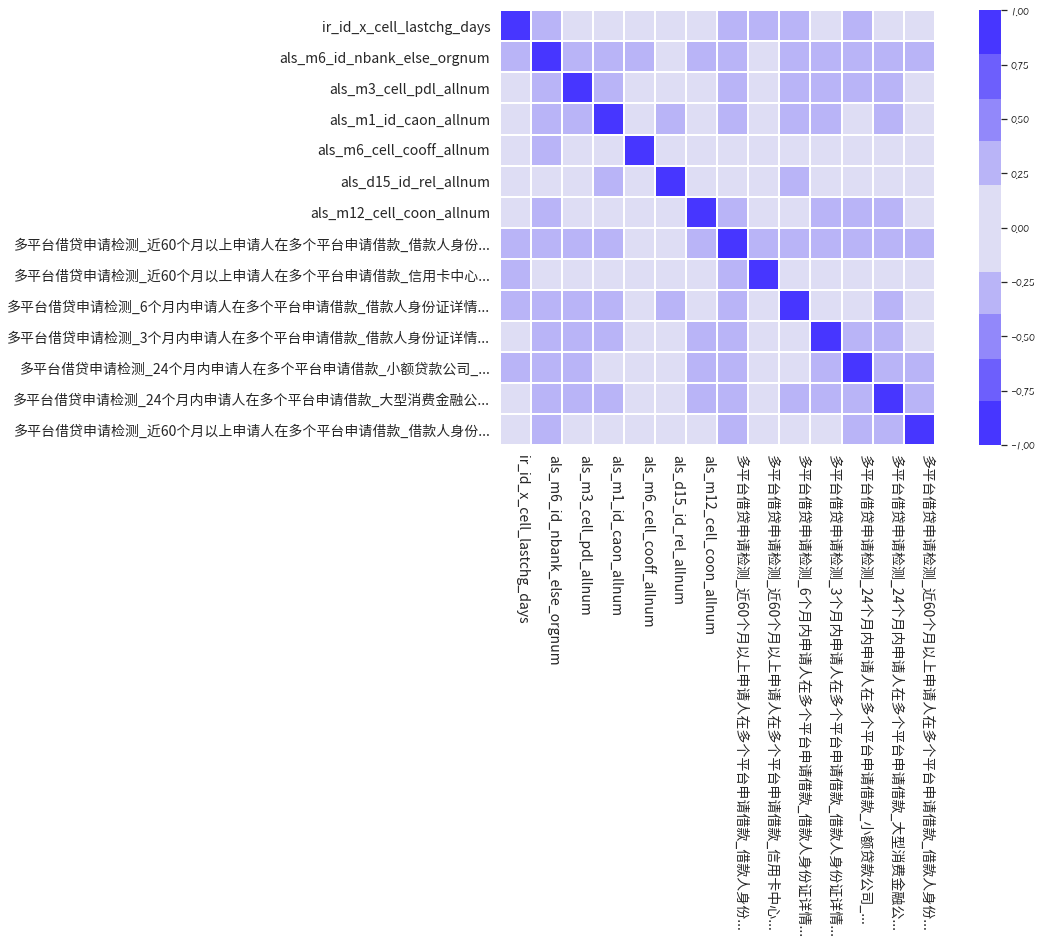

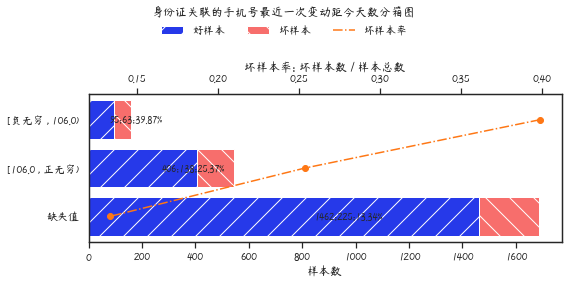

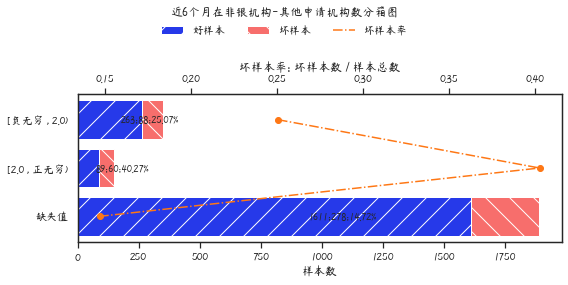

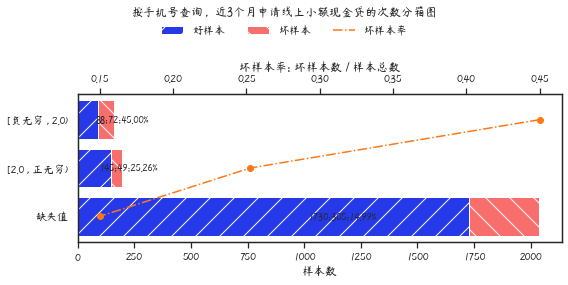

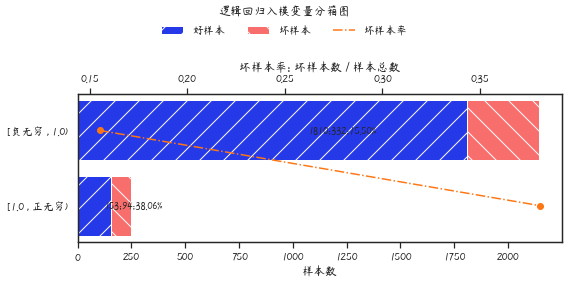

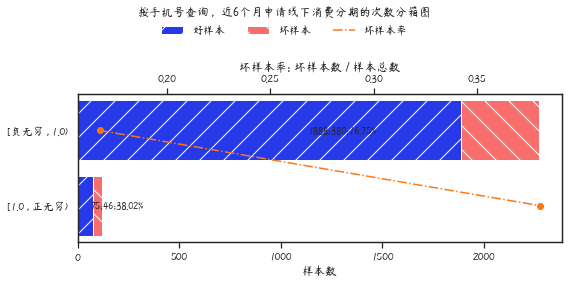

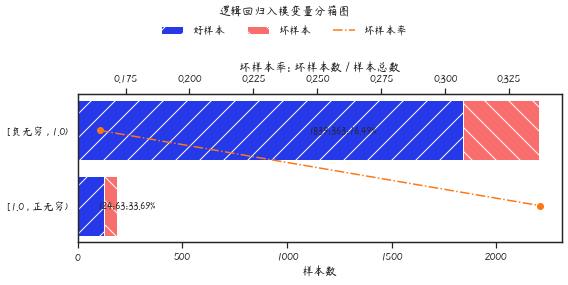

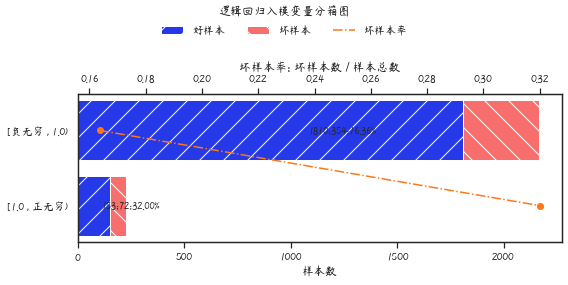

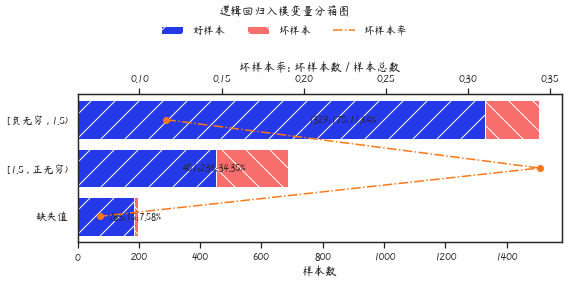

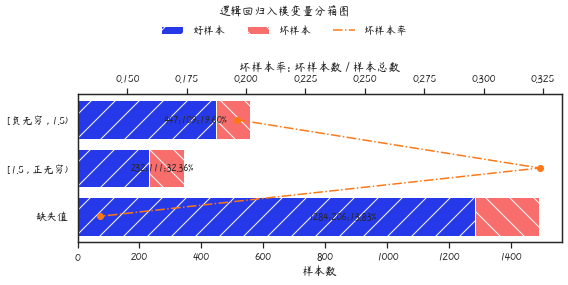

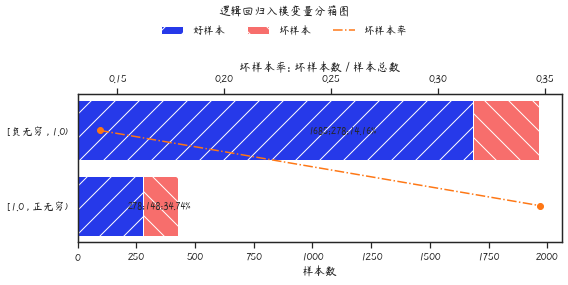

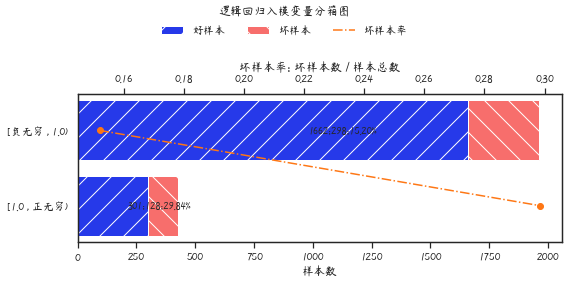

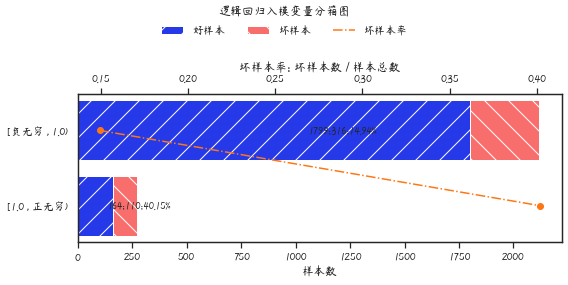

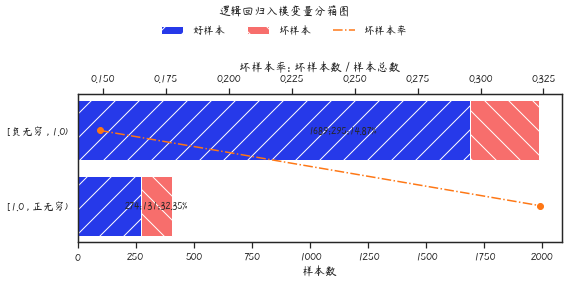

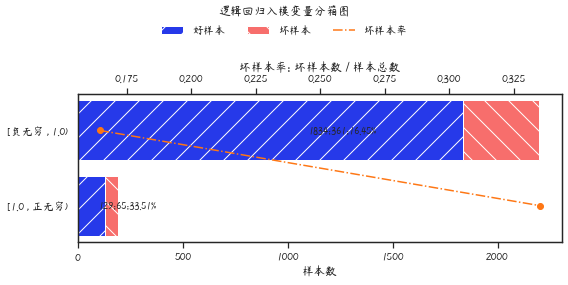

In [256]:
# ////////////////////////////////////// 特征概述 ///////////////////////////////////// #
worksheet = writer.get_sheet_by_name("模型变量信息")

start_row, start_col = 2, 2
end_row, end_col = writer.insert_value2sheet(worksheet, (start_row, start_col), value="入模变量信息", style="header")
end_row, end_col = writer.insert_df2sheet(worksheet, feature_describe.query("变量名 in @card.features_").reset_index(drop=True).reset_index().rename(columns={"index": "序号"}), (end_row + 1, start_col))

# 变量分布情况
import toad
data_info = toad.detect(train[card.rules.keys()]).reset_index().rename(columns={"index": "变量名称", "type": "变量类型", "size": "样本个数", "missing": "缺失值", "unique": "唯一值个数"})
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="变量分布情况", style="header")
end_row, end_col = writer.insert_df2sheet(worksheet, data_info, (end_row + 1, start_col))

# 变量相关性
data_corr = woe_train[card.features_].corr()
logistic.corr(woe_train[card.features_ + [target]], save="model_report/train_corr.png", annot=False)
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="变量相关性", style="header")
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/train_corr.png", (end_row + 1, start_col), figsize=(700, 500))
end_row, end_col = writer.insert_df2sheet(worksheet, data_corr.reset_index().rename(columns={"index": ""}), (end_row + 1, start_col))

conditional_column = f"{get_column_letter(start_col + 1)}{end_row - len(data_corr)}:{get_column_letter(end_col - 1)}{end_row - 1}"
worksheet.conditional_formatting.add(conditional_column, ColorScaleRule(start_type='num', start_value=-1.0, start_color='0000ff', mid_type='num', mid_value=0., mid_color='FFFFFF', end_type='num', end_value=1.0, end_color='0000ff'))


# 变量分箱信息
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="变量分箱信息", style="header")

for col in logistic.feature_names_in_:
    feature_table = feature_bin_stats(train, col, target=target, desc=feature_map.get(col, "") or "逻辑回归入模变量", combiner=combiner)
    _ = bin_plot(feature_table, desc=feature_map.get(col, "") or "逻辑回归入模变量", figsize=(8, 4), save=f"model_report/bin_plots/data_{col}.png")
    
    end_row, end_col = writer.insert_pic2sheet(worksheet, f"model_report/bin_plots/data_{col}.png", (end_row + 1, start_col), figsize=(700, 400))
    end_row, end_col = writer.insert_df2sheet(worksheet, feature_table, (end_row, start_col))

    for c in ["坏样本率", "LIFT值"]:
        conditional_column = get_column_letter(start_col + feature_table.columns.get_loc(c))
        writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row - len(feature_table)}', f'{conditional_column}{end_row}')

    for c in ["样本占比", "好样本占比", "坏样本占比", "坏样本率", "LIFT值", "累积LIFT值"]:
        conditional_column = get_column_letter(start_col + feature_table.columns.get_loc(c))
        writer.set_number_format(worksheet, f"{conditional_column}{end_row - len(feature_table)}:{conditional_column}{end_row}", "0.00%")

In [257]:
train["score"] = card.predict(train)
oot["score"] = card.predict(oot)

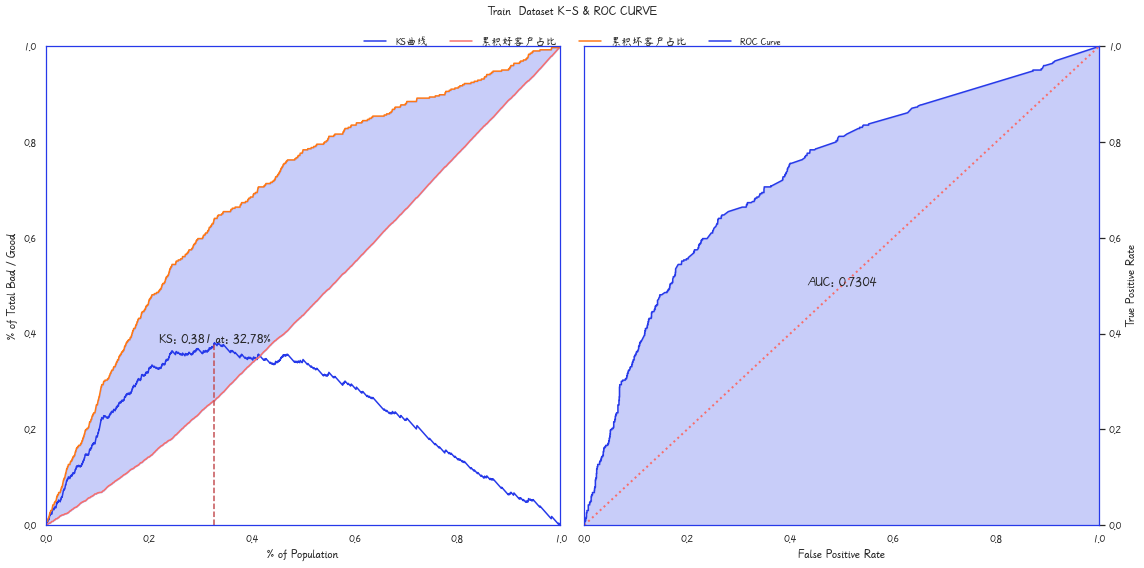

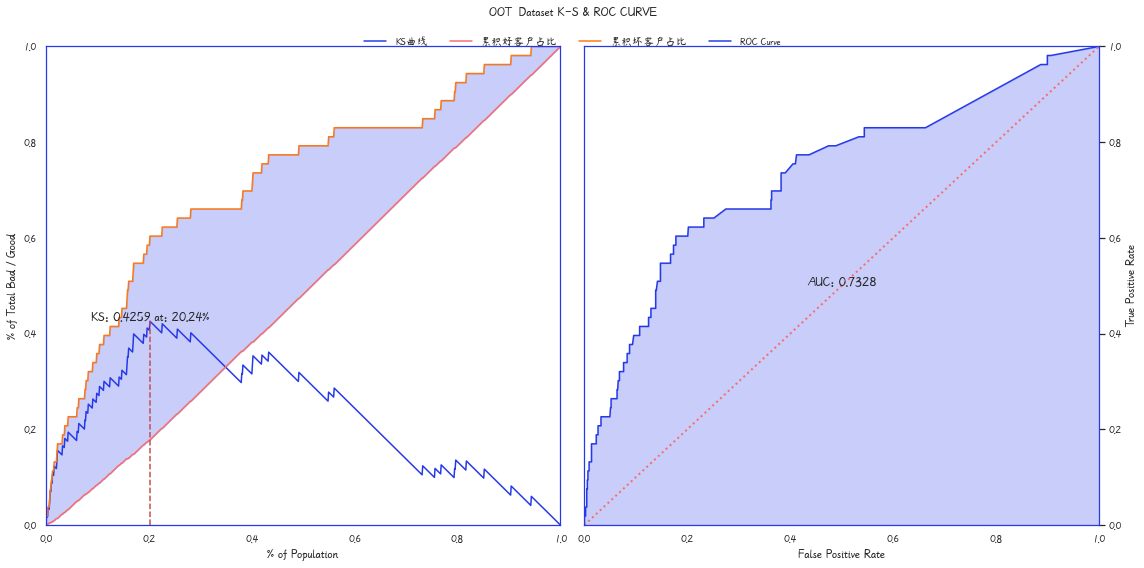

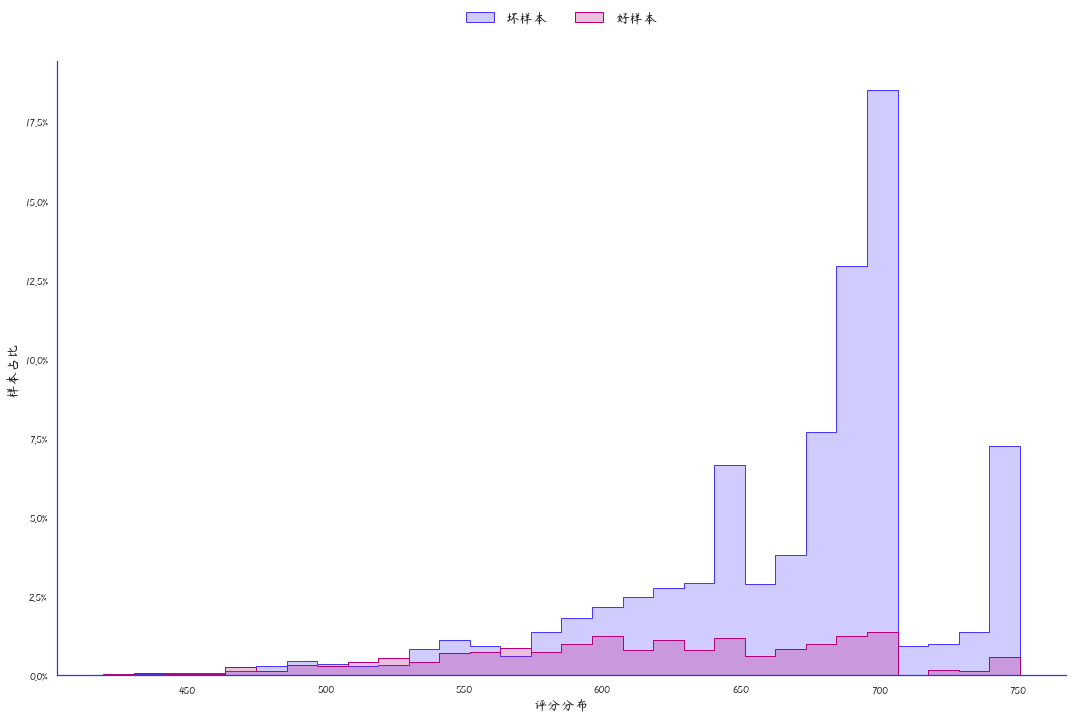

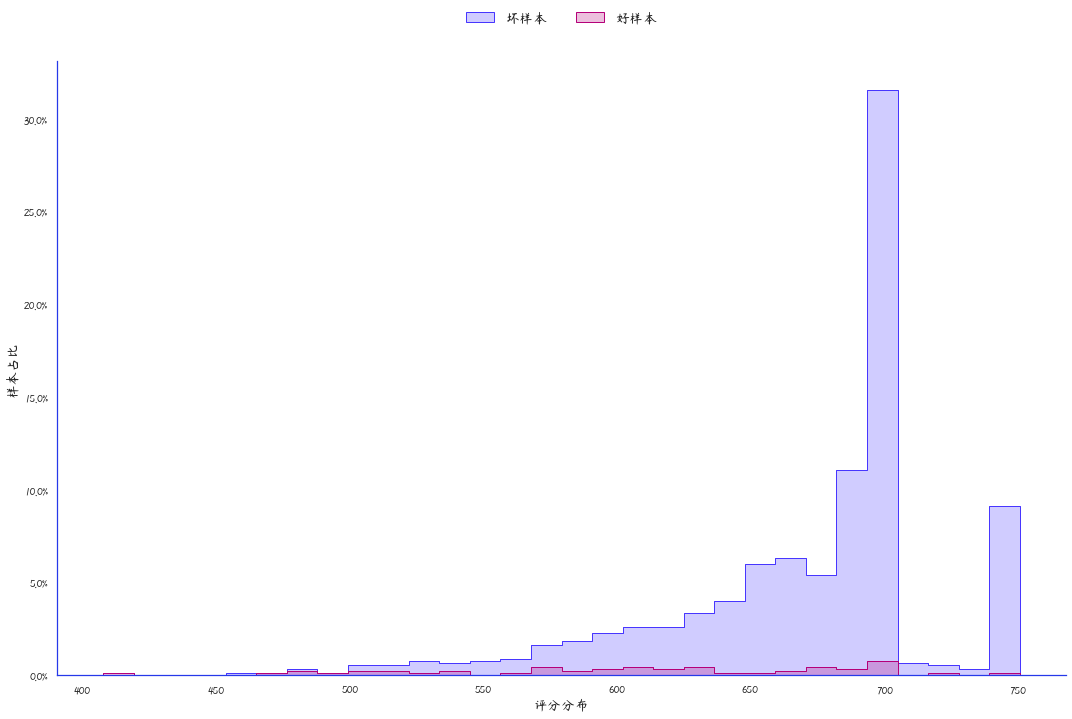

In [258]:
# ////////////////////////////////////// 评分卡说明 ///////////////////////////////////// #
worksheet = writer.get_sheet_by_name("评分卡结果")

# 评分卡刻度
scorecard_kedu = card.scorecard_scale()
scorecard_points = card.scorecard_points(feature_map=feature_map)
scorecard_clip = card.score_clip(train["score"], clip=25)

start_row, start_col = 2, 2
end_row, end_col = writer.insert_value2sheet(worksheet, (start_row, start_col), value="评分卡刻度", style="header")
end_row, end_col = writer.insert_df2sheet(worksheet, scorecard_kedu, (end_row + 1, start_col))

# 评分卡对应分数
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="评分卡分数", style="header")
end_row, end_col = writer.insert_df2sheet(worksheet, scorecard_points, (end_row + 1, start_col), merge_column="变量名称")

# 评分效果
score_table_train = feature_bin_stats(train, "score", desc="建模集模型评分", target=target, rules=scorecard_clip)
score_table_test = feature_bin_stats(oot, "score", desc="跨时间验证集模型评分", target=target, rules=scorecard_clip)

# sp.bin_plot(score_table_train, desc="测试集模型评分", figsize=(10, 6))
# sp.bin_plot(score_table_test, desc="测试集模型评分", figsize=(10, 6))

ks_plot(train["score"], train[target], title="Train \tDataset", save="model_report/train_ksplot.png")
ks_plot(oot["score"], oot[target], title="OOT \tDataset", save="model_report/test_ksplot.png")

hist_plot(train["score"], train[target], save="model_report/train_scorehist.png", bins=30)
hist_plot(oot["score"], oot[target], save="model_report/test_scorehist.png", bins=30)

end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="建模集评分模型效果", style="header")
ks_row = end_row
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/train_ksplot.png", (ks_row, start_col))
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/train_scorehist.png", (ks_row, end_col))
end_row, end_col = writer.insert_df2sheet(worksheet, score_table_train, (end_row + 1, start_col))

for c in ["坏样本率", "LIFT值", "分档KS值"]:
    conditional_column = get_column_letter(start_col + score_table_train.columns.get_loc(c))
    writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row - len(score_table_train)}', f'{conditional_column}{end_row}')

for c in ["样本占比", "好样本占比", "坏样本占比", "坏样本率", "LIFT值", "累积LIFT值", "分档KS值"]:
    conditional_column = get_column_letter(start_col + score_table_train.columns.get_loc(c))
    writer.set_number_format(worksheet, f"{conditional_column}{end_row - len(score_table_train)}:{conditional_column}{end_row}", "0.00%")

end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="跨时间验证集评分模型效果", style="header")
ks_row = end_row
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/test_ksplot.png", (ks_row, start_col))
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/test_scorehist.png", (ks_row, end_col))
end_row, end_col = writer.insert_df2sheet(worksheet, score_table_test, (end_row + 1, start_col))

for c in ["坏样本率", "LIFT值", "分档KS值"]:
    conditional_column = get_column_letter(start_col + score_table_test.columns.get_loc(c))
    writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row - len(score_table_test)}', f'{conditional_column}{end_row}')

for c in ["样本占比", "好样本占比", "坏样本占比", "坏样本率", "LIFT值", "累积LIFT值", "分档KS值"]:
    conditional_column = get_column_letter(start_col + score_table_test.columns.get_loc(c))
    writer.set_number_format(worksheet, f"{conditional_column}{end_row - len(score_table_test)}:{conditional_column}{end_row}", "0.00%")

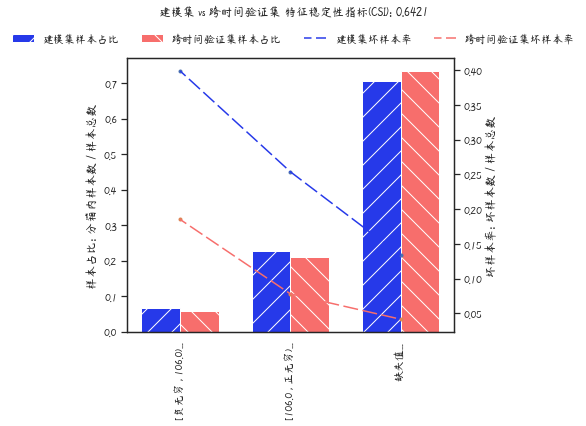

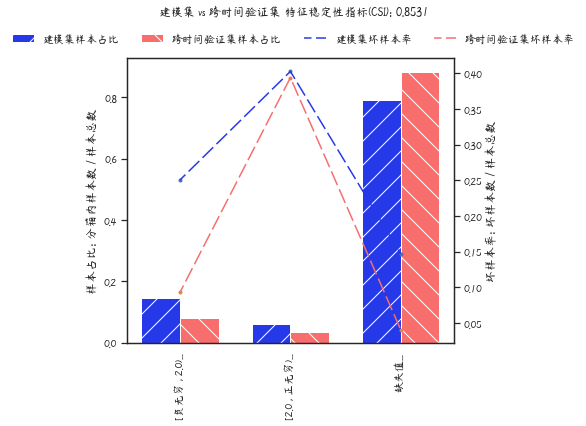

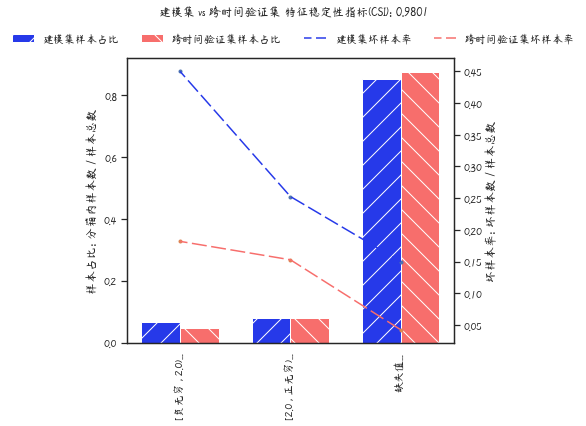

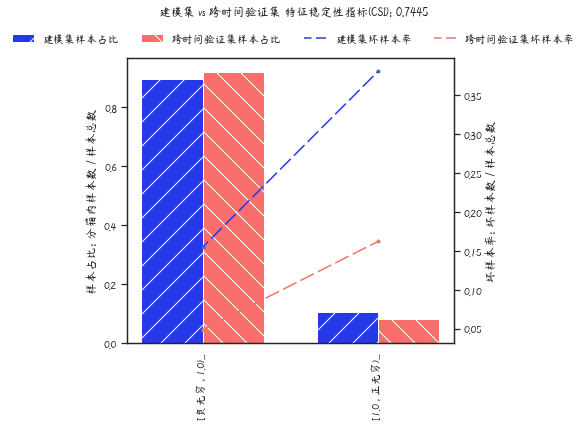

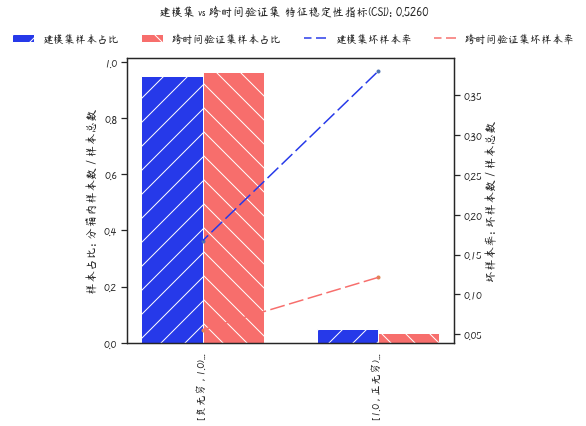

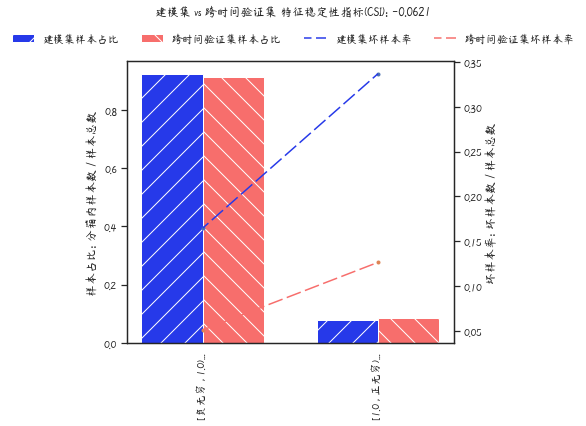

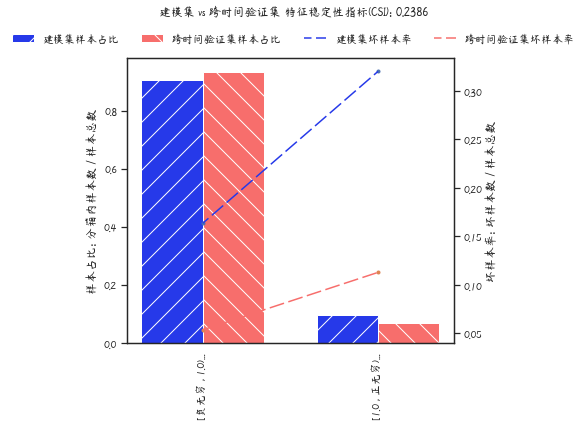

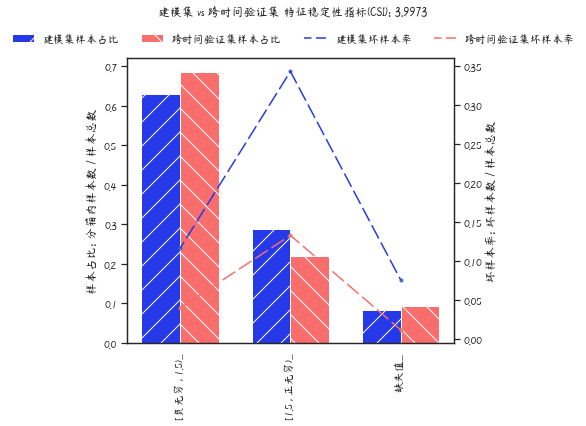

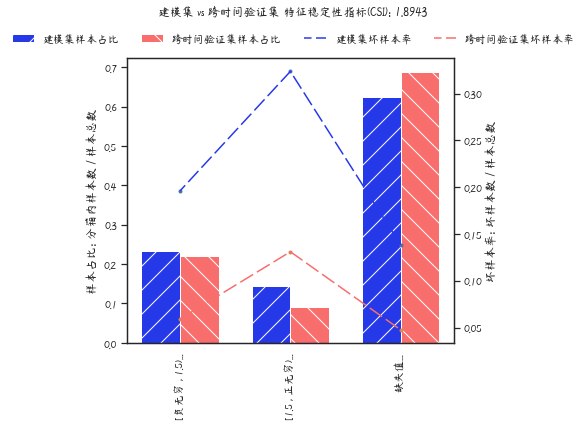

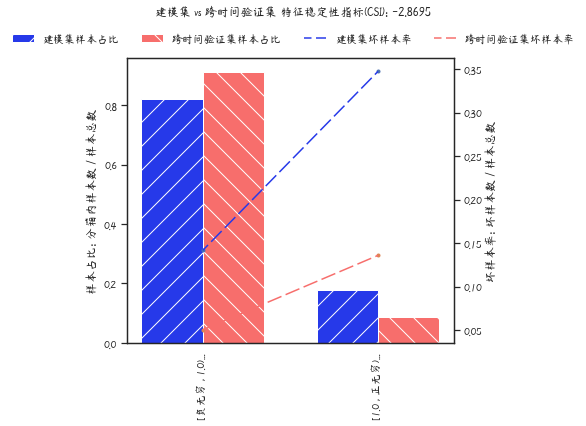

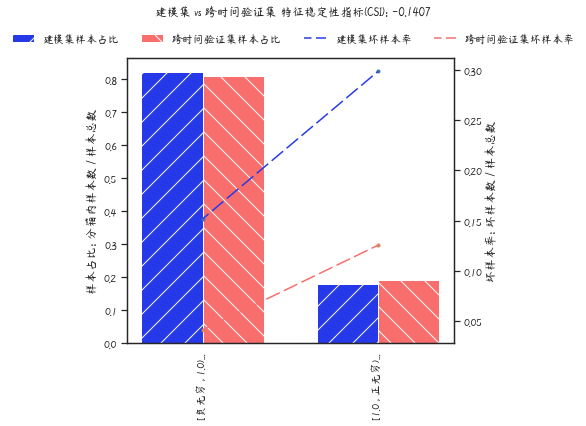

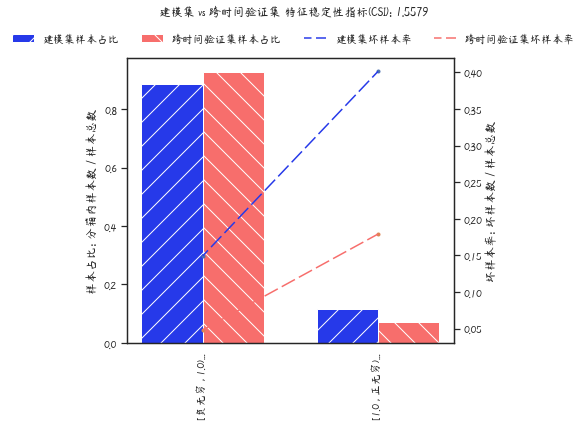

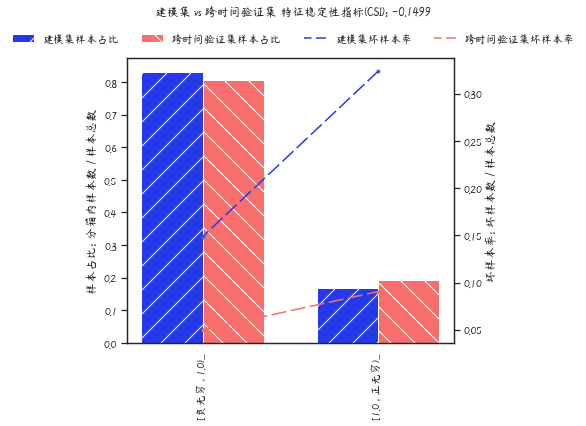

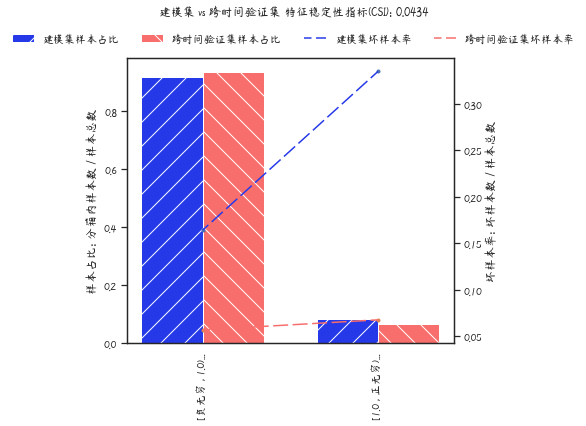

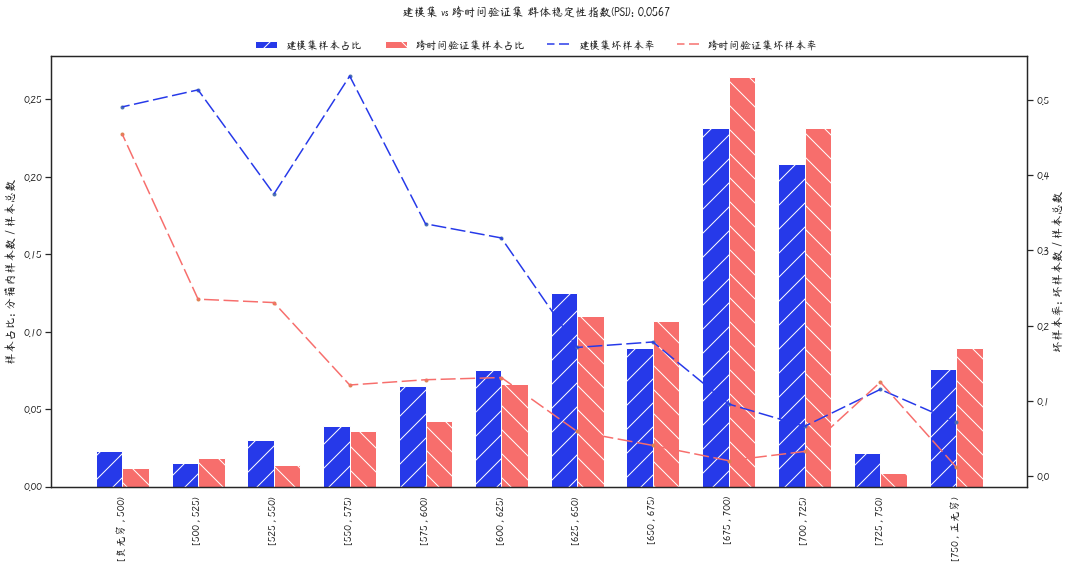

In [259]:
# ////////////////////////////////////// 模型稳定性 ///////////////////////////////////// #
worksheet = writer.get_sheet_by_name("模型稳定性")
start_row, start_col = 2, 2

# 变量 CSI 表
end_row, end_col = writer.insert_value2sheet(worksheet, (start_row, start_col), value="入模变量稳定性指标 (Characteristic Stability Index, CSI): 建模集 vs 跨时间验证集", style="header")

for col in card._feature_names:
    feature_table_train = feature_bin_stats(train, col, target=target, desc=feature_map.get(col, "") or "逻辑回归入模变量", combiner=combiner)
    feature_table_test = feature_bin_stats(oot, col, target=target, desc=feature_map.get(col, "") or "逻辑回归入模变量", combiner=combiner)
    train_test_csi_table = csi_plot(feature_table_train, feature_table_test, card[col], result=True, plot=True, max_len=35, figsize=(6, 6), labels=["建模集", "跨时间验证集"], save=f"model_report/csi_{col}.png")
    
    end_row, end_col = writer.insert_pic2sheet(worksheet, f"model_report/csi_{col}.png", (end_row, start_col), figsize=(600, 400))
    end_row, end_col = writer.insert_df2sheet(worksheet, train_test_csi_table, (end_row + 1, start_col))
    
    conditional_column = get_column_letter(start_col + train_test_csi_table.columns.get_loc("分档CSI值"))
    writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(train_test_csi_table)}', f'{conditional_column}{end_row}')

    for c in ["建模集样本占比", "建模集坏样本率", "跨时间验证集样本占比", "跨时间验证集坏样本率"]:
        conditional_column = get_column_letter(start_col + train_test_csi_table.columns.get_loc(c))
        writer.set_number_format(worksheet, f"{conditional_column}{end_row - len(train_test_csi_table)}:{conditional_column}{end_row}", "0.00%")

# 评分分布稳定性
train_test_score_psi = psi_plot(score_table_train, score_table_test, labels=["建模集", "跨时间验证集"], save="model_report/train_test_psiplot.png", result=True)

end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="模型评分稳定性指标 (Population Stability Index, PSI): 建模集 vs 跨时间验证集", style="header")
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/train_test_psiplot.png", (end_row, start_col), figsize=(1000, 400))
end_row, end_col = writer.insert_df2sheet(worksheet, train_test_score_psi, (end_row + 1, start_col))

conditional_column = get_column_letter(start_col + train_test_score_psi.columns.get_loc("分档PSI值"))
writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(train_test_score_psi)}', f'{conditional_column}{end_row}')

for c in ["建模集样本占比", "建模集坏样本率", "跨时间验证集样本占比", "跨时间验证集坏样本率"]:
    conditional_column = get_column_letter(start_col + train_test_score_psi.columns.get_loc(c))
    writer.set_number_format(worksheet, f"{conditional_column}{end_row - len(train_test_score_psi)}:{conditional_column}{end_row}", "0.00%")

In [260]:
writer.save("model_report/评分卡模型报告.xlsx")